<a href="https://colab.research.google.com/github/yevintheenura01/DL_Assignment/blob/Manoj/diabetes_Prediction_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Cell 1: Setup & GPU check
import sys
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check TensorFlow and GPU
import tensorflow as tf
print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Display plots inline (Colab)
%matplotlib inline


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
TensorFlow: 2.19.0
GPUs: []


In [ ]:
# Cell 2: Load dataset (upload fallback to /mnt/data/diabetes (2).csv)
from google.colab import files

# Let user upload a file, otherwise fallback to known path
uploaded = files.upload()  # If you uploaded, this will appear as dict
if uploaded:
    # pick first uploaded file
    fname = list(uploaded.keys())[0]
    print("Using uploaded file:", fname)
    df = pd.read_csv(fname)
else:
    fallback = '/mnt/data/diabetes (2).csv'
    print("No upload detected. Falling back to:", fallback)
    df = pd.read_csv(fallback)

print("Dataset shape:", df.shape)
df.head()


Saving diabetes (2).csv to diabetes (2).csv
Using uploaded file: diabetes (2).csv
Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
# Cell 3: EDA: summary & distributions
print("Columns:", df.columns.tolist())
print("\nInfo:")
display(df.info())
print("\nSummary statistics:")
display(df.describe())

# Check class balance
if 'Outcome' in df.columns:
    print("\nClass distribution:")
    display(df['Outcome'].value_counts())
else:
    # Try common variants
    possible_targets = [c for c in df.columns if c.lower() in ('target','diabetes','outcome','class')]
    print("No 'Outcome' column found. Candidates:", possible_targets)


Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None


Summary statistics:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Class distribution:


,count
Outcome,
0,500
1,268


In [ ]:
# Cell 4: Preprocessing assumptions and cleaning
# For Pima-like diabetes datasets: certain columns have 0 as missing (Glucose, BloodPressure, SkinThickness, Insulin, BMI)
# We'll replace zeros with median for those columns if they exist.

df_clean = df.copy()

# Identify target column
if 'Outcome' in df_clean.columns:
    TARGET = 'Outcome'
else:
    # fallback guess
    for c in df_clean.columns:
        if c.lower() in ('target','diabetes','outcome','class'):
            TARGET = c
            break
    else:
        raise ValueError("Target column not found. Ensure dataset has 'Outcome' or target column.")

zero_as_missing = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
present = [c for c in zero_as_missing if c in df_clean.columns]
print("Columns treating 0 as missing:", present)

for c in present:
    # replace zeros with NaN then median
    df_clean[c] = df_clean[c].replace(0, np.nan)
    median_val = df_clean[c].median()
    df_clean[c] = df_clean[c].fillna(median_val)
    print(f"Column {c}: replaced missing zeros with median {median_val:.4f}")

# If any other nulls remaining, impute with median
nulls = df_clean.isna().sum()
print("\nNulls per column after cleaning:")
print(nulls[nulls>0])

# Final check
display(df_clean.head())


Columns treating 0 as missing: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
Column Glucose: replaced missing zeros with median 117.0000
Column BloodPressure: replaced missing zeros with median 72.0000
Column SkinThickness: replaced missing zeros with median 29.0000
Column Insulin: replaced missing zeros with median 125.0000
Column BMI: replaced missing zeros with median 32.3000

Nulls per column after cleaning:
Series([], dtype: int64)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [ ]:
# Cell 5: Features, splits, scaling, reshape for 1D CNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_clean.drop(columns=[TARGET]).values
y = df_clean[TARGET].values

# Train/val/test split: 70/15/15 (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# Scale features (fit on train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# Reshape for Conv1D: (samples, timesteps, channels) -> treat features as "timesteps"
# We'll set channels=1
X_train_c = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_c   = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_c  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Conv1D shapes:", X_train_c.shape, X_val_c.shape, X_test_c.shape)


Shapes: (537, 8) (115, 8) (116, 8)
Conv1D shapes: (537, 8, 1) (115, 8, 1) (116, 8, 1)


In [13]:
# Cell 6: Build 1D-CNN model with regularization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, GlobalAveragePooling1D, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def build_cnn(input_shape, lr=1e-3, l2=1e-4, dropout_rate=0.3):
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Block 1
    model.add(Conv1D(64, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    # Block 2
    model.add(Conv1D(128, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    # Block 3
    model.add(Conv1D(128, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(GlobalAveragePooling1D())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC', 'Accuracy'])
    return model

input_shape = X_train_c.shape[1:]
model = build_cnn(input_shape, lr=1e-3)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 8, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,841 (327.50 KB)

 Trainable params: 83,201 (325.00 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Cell 7: Callbacks and class weights
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Save best model
model_path = "best_cnn_diabetes.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_auc', mode='max', save_best_only=True, verbose=1)

# Early stopping
early = EarlyStopping(monitor='val_auc', mode='max', patience=20, restore_best_weights=True, verbose=1)

# Reduce LR on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=8, verbose=1, min_lr=1e-6)

# Class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.7671428571428571), 1: np.float64(1.4358288770053476)}


In [ ]:
# Cell 8: Train
epochs = 150
batch_size = 32

history = model.fit(
    X_train_c, y_train,
    validation_data=(X_val_c, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint, early, reduce_lr],
    class_weight=class_weights,
    verbose=2
)


Epoch 1/150


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_auc available.
  if self._should_save_model(epoch, batch, logs, filepath):


17/17 - 6s - 357ms/step - AUC: 0.7671 - Accuracy: 0.6909 - loss: 0.6023 - val_AUC: 0.7870 - val_Accuracy: 0.7304 - val_loss: 0.6639 - learning_rate: 1.0000e-03
Epoch 2/150


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,Accuracy,loss,val_AUC,val_Accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: AUC,Accuracy,loss,val_AUC,val_Accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


17/17 - 0s - 23ms/step - AUC: 0.7995 - Accuracy: 0.7225 - loss: 0.5751 - val_AUC: 0.7900 - val_Accuracy: 0.6783 - val_loss: 0.6632 - learning_rate: 1.0000e-03
Epoch 3/150


17/17 - 0s - 21ms/step - AUC: 0.8005 - Accuracy: 0.6927 - loss: 0.5653 - val_AUC: 0.7928 - val_Accuracy: 0.6783 - val_loss: 0.6606 - learning_rate: 1.0000e-03
Epoch 4/150


17/17 - 0s - 23ms/step - AUC: 0.8055 - Accuracy: 0.7300 - loss: 0.5714 - val_AUC: 0.8097 - val_Accuracy: 0.6957 - val_loss: 0.6512 - learning_rate: 1.0000e-03
Epoch 5/150


17/17 - 0s - 20ms/step - AUC: 0.8355 - Accuracy: 0.7393 - loss: 0.5307 - val_AUC: 0.8000 - val_Accuracy: 0.6870 - val_loss: 0.6536 - learning_rate: 1.0000e-03
Epoch 6/150


17/17 - 0s - 21ms/step - AUC: 0.8217 - Accuracy: 0.7412 - loss: 0.5431 - val_AUC: 0.8125 - val_Accuracy: 0.6870 - val_loss: 0.6602 - learning_rate: 1.0000e-03
Epoch 7/150


17/17 - 0s - 28ms/step - AUC: 0.8285 - Accuracy: 0.7486 - loss: 0.5385 - val_AUC: 0.8165 - val_Accuracy: 0.6870 - val_loss: 0.6571 - learning_rate: 1.0000e-03
Epoch 8/150


17/17 - 0s - 23ms/step - AUC: 0.8379 - Accuracy: 0.7654 - loss: 0.5246 - val_AUC: 0.8155 - val_Accuracy: 0.6870 - val_loss: 0.6378 - learning_rate: 1.0000e-03
Epoch 9/150


17/17 - 0s - 22ms/step - AUC: 0.8408 - Accuracy: 0.7505 - loss: 0.5208 - val_AUC: 0.8162 - val_Accuracy: 0.6870 - val_loss: 0.6412 - learning_rate: 1.0000e-03
Epoch 10/150


17/17 - 1s - 34ms/step - AUC: 0.8450 - Accuracy: 0.7505 - loss: 0.5200 - val_AUC: 0.8185 - val_Accuracy: 0.6870 - val_loss: 0.6473 - learning_rate: 1.0000e-03
Epoch 11/150


17/17 - 1s - 38ms/step - AUC: 0.8414 - Accuracy: 0.7486 - loss: 0.5196 - val_AUC: 0.8292 - val_Accuracy: 0.6957 - val_loss: 0.6287 - learning_rate: 1.0000e-03
Epoch 12/150


17/17 - 0s - 21ms/step - AUC: 0.8536 - Accuracy: 0.7765 - loss: 0.5039 - val_AUC: 0.8282 - val_Accuracy: 0.7304 - val_loss: 0.5773 - learning_rate: 1.0000e-03
Epoch 13/150


17/17 - 0s - 23ms/step - AUC: 0.8531 - Accuracy: 0.7728 - loss: 0.5136 - val_AUC: 0.8347 - val_Accuracy: 0.7217 - val_loss: 0.5766 - learning_rate: 1.0000e-03
Epoch 14/150


17/17 - 0s - 20ms/step - AUC: 0.8539 - Accuracy: 0.7654 - loss: 0.5021 - val_AUC: 0.8508 - val_Accuracy: 0.7478 - val_loss: 0.5530 - learning_rate: 1.0000e-03
Epoch 15/150


17/17 - 0s - 20ms/step - AUC: 0.8640 - Accuracy: 0.7784 - loss: 0.4963 - val_AUC: 0.8427 - val_Accuracy: 0.7304 - val_loss: 0.5850 - learning_rate: 1.0000e-03
Epoch 16/150


17/17 - 1s - 35ms/step - AUC: 0.8610 - Accuracy: 0.7765 - loss: 0.4901 - val_AUC: 0.8517 - val_Accuracy: 0.7652 - val_loss: 0.5236 - learning_rate: 1.0000e-03
Epoch 17/150


17/17 - 1s - 76ms/step - AUC: 0.8583 - Accuracy: 0.7654 - loss: 0.4994 - val_AUC: 0.8512 - val_Accuracy: 0.7652 - val_loss: 0.5462 - learning_rate: 1.0000e-03
Epoch 18/150


17/17 - 1s - 31ms/step - AUC: 0.8538 - Accuracy: 0.7784 - loss: 0.5065 - val_AUC: 0.8447 - val_Accuracy: 0.7565 - val_loss: 0.5334 - learning_rate: 1.0000e-03
Epoch 19/150


17/17 - 0s - 25ms/step - AUC: 0.8719 - Accuracy: 0.7952 - loss: 0.4814 - val_AUC: 0.8487 - val_Accuracy: 0.7565 - val_loss: 0.5272 - learning_rate: 1.0000e-03
Epoch 20/150


17/17 - 1s - 32ms/step - AUC: 0.8723 - Accuracy: 0.7765 - loss: 0.4811 - val_AUC: 0.8473 - val_Accuracy: 0.7478 - val_loss: 0.5284 - learning_rate: 1.0000e-03
Epoch 21/150


17/17 - 0s - 22ms/step - AUC: 0.8798 - Accuracy: 0.7896 - loss: 0.4616 - val_AUC: 0.8533 - val_Accuracy: 0.7565 - val_loss: 0.5267 - learning_rate: 1.0000e-03
Epoch 22/150


17/17 - 0s - 19ms/step - AUC: 0.8680 - Accuracy: 0.7803 - loss: 0.4776 - val_AUC: 0.8497 - val_Accuracy: 0.7391 - val_loss: 0.5613 - learning_rate: 1.0000e-03
Epoch 23/150


17/17 - 0s - 21ms/step - AUC: 0.8586 - Accuracy: 0.7691 - loss: 0.4921 - val_AUC: 0.8453 - val_Accuracy: 0.7565 - val_loss: 0.5399 - learning_rate: 1.0000e-03
Epoch 24/150


17/17 - 0s - 22ms/step - AUC: 0.8714 - Accuracy: 0.7914 - loss: 0.4816 - val_AUC: 0.8460 - val_Accuracy: 0.7739 - val_loss: 0.4963 - learning_rate: 1.0000e-03
Epoch 25/150


17/17 - 0s - 19ms/step - AUC: 0.8766 - Accuracy: 0.7896 - loss: 0.4718 - val_AUC: 0.8507 - val_Accuracy: 0.7652 - val_loss: 0.5126 - learning_rate: 1.0000e-03
Epoch 26/150


17/17 - 0s - 21ms/step - AUC: 0.8771 - Accuracy: 0.7896 - loss: 0.4698 - val_AUC: 0.8453 - val_Accuracy: 0.7478 - val_loss: 0.5453 - learning_rate: 1.0000e-03
Epoch 27/150


17/17 - 0s - 20ms/step - AUC: 0.8748 - Accuracy: 0.7933 - loss: 0.4693 - val_AUC: 0.8437 - val_Accuracy: 0.7652 - val_loss: 0.5044 - learning_rate: 1.0000e-03
Epoch 28/150


17/17 - 0s - 20ms/step - AUC: 0.8807 - Accuracy: 0.7914 - loss: 0.4633 - val_AUC: 0.8355 - val_Accuracy: 0.7565 - val_loss: 0.5385 - learning_rate: 1.0000e-03
Epoch 29/150


17/17 - 0s - 20ms/step - AUC: 0.8719 - Accuracy: 0.7821 - loss: 0.4776 - val_AUC: 0.8468 - val_Accuracy: 0.7652 - val_loss: 0.5244 - learning_rate: 1.0000e-03
Epoch 30/150


17/17 - 0s - 21ms/step - AUC: 0.8883 - Accuracy: 0.7896 - loss: 0.4494 - val_AUC: 0.8447 - val_Accuracy: 0.7478 - val_loss: 0.5381 - learning_rate: 1.0000e-03
Epoch 31/150


17/17 - 0s - 23ms/step - AUC: 0.8758 - Accuracy: 0.7877 - loss: 0.4698 - val_AUC: 0.8443 - val_Accuracy: 0.7565 - val_loss: 0.5682 - learning_rate: 1.0000e-03
Epoch 32/150


17/17 - 0s - 21ms/step - AUC: 0.8828 - Accuracy: 0.7933 - loss: 0.4619 - val_AUC: 0.8488 - val_Accuracy: 0.7565 - val_loss: 0.5576 - learning_rate: 1.0000e-03
Epoch 33/150


17/17 - 0s - 23ms/step - AUC: 0.8757 - Accuracy: 0.7914 - loss: 0.4735 - val_AUC: 0.8500 - val_Accuracy: 0.7652 - val_loss: 0.5309 - learning_rate: 1.0000e-03
Epoch 34/150


17/17 - 0s - 21ms/step - AUC: 0.8883 - Accuracy: 0.7952 - loss: 0.4488 - val_AUC: 0.8512 - val_Accuracy: 0.7652 - val_loss: 0.5312 - learning_rate: 1.0000e-03
Epoch 35/150


17/17 - 0s - 23ms/step - AUC: 0.8940 - Accuracy: 0.8138 - loss: 0.4403 - val_AUC: 0.8512 - val_Accuracy: 0.7913 - val_loss: 0.5491 - learning_rate: 1.0000e-03
Epoch 36/150


17/17 - 0s - 22ms/step - AUC: 0.8839 - Accuracy: 0.8045 - loss: 0.4510 - val_AUC: 0.8495 - val_Accuracy: 0.7739 - val_loss: 0.5300 - learning_rate: 1.0000e-03
Epoch 37/150


17/17 - 0s - 22ms/step - AUC: 0.8919 - Accuracy: 0.7952 - loss: 0.4436 - val_AUC: 0.8447 - val_Accuracy: 0.7391 - val_loss: 0.5524 - learning_rate: 1.0000e-03
Epoch 38/150


17/17 - 0s - 23ms/step - AUC: 0.8882 - Accuracy: 0.8082 - loss: 0.4497 - val_AUC: 0.8560 - val_Accuracy: 0.7826 - val_loss: 0.5186 - learning_rate: 1.0000e-03
Epoch 39/150


17/17 - 1s - 39ms/step - AUC: 0.9024 - Accuracy: 0.8082 - loss: 0.4282 - val_AUC: 0.8547 - val_Accuracy: 0.7913 - val_loss: 0.4998 - learning_rate: 1.0000e-03
Epoch 40/150


17/17 - 0s - 27ms/step - AUC: 0.8957 - Accuracy: 0.8119 - loss: 0.4358 - val_AUC: 0.8503 - val_Accuracy: 0.7739 - val_loss: 0.5649 - learning_rate: 1.0000e-03
Epoch 41/150


17/17 - 0s - 24ms/step - AUC: 0.8867 - Accuracy: 0.8082 - loss: 0.4489 - val_AUC: 0.8548 - val_Accuracy: 0.7565 - val_loss: 0.4991 - learning_rate: 1.0000e-03
Epoch 42/150


17/17 - 0s - 27ms/step - AUC: 0.8879 - Accuracy: 0.7970 - loss: 0.4466 - val_AUC: 0.8437 - val_Accuracy: 0.7478 - val_loss: 0.5163 - learning_rate: 1.0000e-03
Epoch 43/150


17/17 - 0s - 27ms/step - AUC: 0.9015 - Accuracy: 0.8305 - loss: 0.4246 - val_AUC: 0.8522 - val_Accuracy: 0.7565 - val_loss: 0.4907 - learning_rate: 1.0000e-03
Epoch 44/150


17/17 - 1s - 43ms/step - AUC: 0.9063 - Accuracy: 0.8324 - loss: 0.4164 - val_AUC: 0.8425 - val_Accuracy: 0.7391 - val_loss: 0.5065 - learning_rate: 1.0000e-03
Epoch 45/150


17/17 - 1s - 32ms/step - AUC: 0.9031 - Accuracy: 0.8026 - loss: 0.4224 - val_AUC: 0.8437 - val_Accuracy: 0.7304 - val_loss: 0.5114 - learning_rate: 1.0000e-03
Epoch 46/150


17/17 - 1s - 36ms/step - AUC: 0.9138 - Accuracy: 0.8138 - loss: 0.4039 - val_AUC: 0.8443 - val_Accuracy: 0.7478 - val_loss: 0.5186 - learning_rate: 1.0000e-03
Epoch 47/150


17/17 - 1s - 32ms/step - AUC: 0.9012 - Accuracy: 0.8231 - loss: 0.4243 - val_AUC: 0.8507 - val_Accuracy: 0.7565 - val_loss: 0.5304 - learning_rate: 1.0000e-03
Epoch 48/150


17/17 - 0s - 20ms/step - AUC: 0.9112 - Accuracy: 0.8175 - loss: 0.4082 - val_AUC: 0.8567 - val_Accuracy: 0.7913 - val_loss: 0.5109 - learning_rate: 1.0000e-03
Epoch 49/150


17/17 - 0s - 20ms/step - AUC: 0.9062 - Accuracy: 0.8119 - loss: 0.4125 - val_AUC: 0.8470 - val_Accuracy: 0.7478 - val_loss: 0.5016 - learning_rate: 1.0000e-03
Epoch 50/150


17/17 - 0s - 20ms/step - AUC: 0.9201 - Accuracy: 0.8287 - loss: 0.3897 - val_AUC: 0.8493 - val_Accuracy: 0.7565 - val_loss: 0.5163 - learning_rate: 1.0000e-03
Epoch 51/150


17/17 - 0s - 21ms/step - AUC: 0.9133 - Accuracy: 0.8231 - loss: 0.3998 - val_AUC: 0.8452 - val_Accuracy: 0.7391 - val_loss: 0.5535 - learning_rate: 1.0000e-03
Epoch 52/150


17/17 - 0s - 21ms/step - AUC: 0.9059 - Accuracy: 0.8156 - loss: 0.4130 - val_AUC: 0.8488 - val_Accuracy: 0.7565 - val_loss: 0.5704 - learning_rate: 1.0000e-03
Epoch 53/150


17/17 - 0s - 23ms/step - AUC: 0.9134 - Accuracy: 0.8101 - loss: 0.3991 - val_AUC: 0.8527 - val_Accuracy: 0.7565 - val_loss: 0.5355 - learning_rate: 1.0000e-03
Epoch 54/150


17/17 - 0s - 21ms/step - AUC: 0.9227 - Accuracy: 0.8156 - loss: 0.3812 - val_AUC: 0.8523 - val_Accuracy: 0.7652 - val_loss: 0.5316 - learning_rate: 1.0000e-03
Epoch 55/150


17/17 - 0s - 21ms/step - AUC: 0.9103 - Accuracy: 0.8361 - loss: 0.4070 - val_AUC: 0.8565 - val_Accuracy: 0.7739 - val_loss: 0.5536 - learning_rate: 1.0000e-03
Epoch 56/150


17/17 - 0s - 23ms/step - AUC: 0.9205 - Accuracy: 0.8231 - loss: 0.3859 - val_AUC: 0.8525 - val_Accuracy: 0.7652 - val_loss: 0.5916 - learning_rate: 1.0000e-03
Epoch 57/150


17/17 - 0s - 21ms/step - AUC: 0.9189 - Accuracy: 0.8175 - loss: 0.3889 - val_AUC: 0.8548 - val_Accuracy: 0.7739 - val_loss: 0.5964 - learning_rate: 1.0000e-03
Epoch 58/150


17/17 - 0s - 21ms/step - AUC: 0.9131 - Accuracy: 0.8194 - loss: 0.4017 - val_AUC: 0.8563 - val_Accuracy: 0.7739 - val_loss: 0.5622 - learning_rate: 1.0000e-03
Epoch 59/150


17/17 - 0s - 21ms/step - AUC: 0.9148 - Accuracy: 0.8287 - loss: 0.3961 - val_AUC: 0.8512 - val_Accuracy: 0.7652 - val_loss: 0.5451 - learning_rate: 1.0000e-03
Epoch 60/150


17/17 - 0s - 25ms/step - AUC: 0.9207 - Accuracy: 0.8194 - loss: 0.3849 - val_AUC: 0.8503 - val_Accuracy: 0.7739 - val_loss: 0.5423 - learning_rate: 1.0000e-03
Epoch 61/150


17/17 - 0s - 24ms/step - AUC: 0.9152 - Accuracy: 0.8156 - loss: 0.3994 - val_AUC: 0.8618 - val_Accuracy: 0.7913 - val_loss: 0.5302 - learning_rate: 1.0000e-03
Epoch 62/150


17/17 - 0s - 22ms/step - AUC: 0.9214 - Accuracy: 0.8324 - loss: 0.3843 - val_AUC: 0.8548 - val_Accuracy: 0.7739 - val_loss: 0.5309 - learning_rate: 1.0000e-03
Epoch 63/150


17/17 - 0s - 20ms/step - AUC: 0.9238 - Accuracy: 0.8417 - loss: 0.3842 - val_AUC: 0.8570 - val_Accuracy: 0.7826 - val_loss: 0.5216 - learning_rate: 1.0000e-03
Epoch 64/150


17/17 - 0s - 23ms/step - AUC: 0.9342 - Accuracy: 0.8436 - loss: 0.3654 - val_AUC: 0.8565 - val_Accuracy: 0.7652 - val_loss: 0.6409 - learning_rate: 1.0000e-03
Epoch 65/150


17/17 - 0s - 22ms/step - AUC: 0.9336 - Accuracy: 0.8492 - loss: 0.3547 - val_AUC: 0.8607 - val_Accuracy: 0.7652 - val_loss: 0.5718 - learning_rate: 1.0000e-03
Epoch 66/150


17/17 - 1s - 45ms/step - AUC: 0.9152 - Accuracy: 0.8305 - loss: 0.3967 - val_AUC: 0.8595 - val_Accuracy: 0.7739 - val_loss: 0.5470 - learning_rate: 1.0000e-03
Epoch 67/150


17/17 - 1s - 52ms/step - AUC: 0.9250 - Accuracy: 0.8380 - loss: 0.3763 - val_AUC: 0.8542 - val_Accuracy: 0.7739 - val_loss: 0.5628 - learning_rate: 1.0000e-03
Epoch 68/150


17/17 - 0s - 21ms/step - AUC: 0.9127 - Accuracy: 0.8138 - loss: 0.4059 - val_AUC: 0.8632 - val_Accuracy: 0.7565 - val_loss: 0.5797 - learning_rate: 1.0000e-03
Epoch 69/150


17/17 - 0s - 20ms/step - AUC: 0.9366 - Accuracy: 0.8492 - loss: 0.3569 - val_AUC: 0.8658 - val_Accuracy: 0.7739 - val_loss: 0.5685 - learning_rate: 1.0000e-03
Epoch 70/150


17/17 - 0s - 21ms/step - AUC: 0.9277 - Accuracy: 0.8305 - loss: 0.3704 - val_AUC: 0.8595 - val_Accuracy: 0.7739 - val_loss: 0.6057 - learning_rate: 1.0000e-03
Epoch 71/150


17/17 - 0s - 19ms/step - AUC: 0.9393 - Accuracy: 0.8417 - loss: 0.3456 - val_AUC: 0.8632 - val_Accuracy: 0.7478 - val_loss: 0.6260 - learning_rate: 1.0000e-03
Epoch 72/150


17/17 - 1s - 30ms/step - AUC: 0.9396 - Accuracy: 0.8529 - loss: 0.3490 - val_AUC: 0.8575 - val_Accuracy: 0.7565 - val_loss: 0.6604 - learning_rate: 1.0000e-03
Epoch 73/150


17/17 - 1s - 31ms/step - AUC: 0.9311 - Accuracy: 0.8324 - loss: 0.3583 - val_AUC: 0.8538 - val_Accuracy: 0.7391 - val_loss: 0.6745 - learning_rate: 1.0000e-03
Epoch 74/150


17/17 - 1s - 31ms/step - AUC: 0.9392 - Accuracy: 0.8454 - loss: 0.3424 - val_AUC: 0.8640 - val_Accuracy: 0.7652 - val_loss: 0.5441 - learning_rate: 1.0000e-03
Epoch 75/150


17/17 - 1s - 38ms/step - AUC: 0.9284 - Accuracy: 0.8417 - loss: 0.3753 - val_AUC: 0.8563 - val_Accuracy: 0.7739 - val_loss: 0.5781 - learning_rate: 1.0000e-03
Epoch 76/150


17/17 - 1s - 31ms/step - AUC: 0.9388 - Accuracy: 0.8510 - loss: 0.3475 - val_AUC: 0.8592 - val_Accuracy: 0.7739 - val_loss: 0.5559 - learning_rate: 1.0000e-03
Epoch 77/150


17/17 - 0s - 25ms/step - AUC: 0.9379 - Accuracy: 0.8566 - loss: 0.3477 - val_AUC: 0.8605 - val_Accuracy: 0.7478 - val_loss: 0.5579 - learning_rate: 1.0000e-03
Epoch 78/150


17/17 - 0s - 20ms/step - AUC: 0.9253 - Accuracy: 0.8305 - loss: 0.3765 - val_AUC: 0.8603 - val_Accuracy: 0.7826 - val_loss: 0.5264 - learning_rate: 1.0000e-03
Epoch 79/150


17/17 - 0s - 21ms/step - AUC: 0.9367 - Accuracy: 0.8492 - loss: 0.3500 - val_AUC: 0.8497 - val_Accuracy: 0.7652 - val_loss: 0.5825 - learning_rate: 1.0000e-03
Epoch 80/150


17/17 - 0s - 21ms/step - AUC: 0.9402 - Accuracy: 0.8622 - loss: 0.3456 - val_AUC: 0.8563 - val_Accuracy: 0.7739 - val_loss: 0.5565 - learning_rate: 1.0000e-03
Epoch 81/150


17/17 - 0s - 20ms/step - AUC: 0.9408 - Accuracy: 0.8436 - loss: 0.3441 - val_AUC: 0.8650 - val_Accuracy: 0.7739 - val_loss: 0.5641 - learning_rate: 1.0000e-03
Epoch 82/150


17/17 - 0s - 21ms/step - AUC: 0.9537 - Accuracy: 0.8678 - loss: 0.3114 - val_AUC: 0.8615 - val_Accuracy: 0.8000 - val_loss: 0.5501 - learning_rate: 1.0000e-03
Epoch 83/150


17/17 - 0s - 21ms/step - AUC: 0.9308 - Accuracy: 0.8436 - loss: 0.3671 - val_AUC: 0.8645 - val_Accuracy: 0.7652 - val_loss: 0.5833 - learning_rate: 1.0000e-03
Epoch 84/150


17/17 - 0s - 23ms/step - AUC: 0.9458 - Accuracy: 0.8510 - loss: 0.3371 - val_AUC: 0.8593 - val_Accuracy: 0.7652 - val_loss: 0.6254 - learning_rate: 1.0000e-03
Epoch 85/150


17/17 - 0s - 23ms/step - AUC: 0.9450 - Accuracy: 0.8641 - loss: 0.3348 - val_AUC: 0.8582 - val_Accuracy: 0.7565 - val_loss: 0.6452 - learning_rate: 1.0000e-03
Epoch 86/150


17/17 - 0s - 20ms/step - AUC: 0.9505 - Accuracy: 0.8547 - loss: 0.3191 - val_AUC: 0.8573 - val_Accuracy: 0.8000 - val_loss: 0.5852 - learning_rate: 1.0000e-03
Epoch 87/150


17/17 - 0s - 21ms/step - AUC: 0.9426 - Accuracy: 0.8436 - loss: 0.3384 - val_AUC: 0.8593 - val_Accuracy: 0.7652 - val_loss: 0.5432 - learning_rate: 1.0000e-03
Epoch 88/150


17/17 - 0s - 22ms/step - AUC: 0.9444 - Accuracy: 0.8566 - loss: 0.3315 - val_AUC: 0.8563 - val_Accuracy: 0.7478 - val_loss: 0.5612 - learning_rate: 1.0000e-03
Epoch 89/150


17/17 - 0s - 23ms/step - AUC: 0.9454 - Accuracy: 0.8585 - loss: 0.3321 - val_AUC: 0.8452 - val_Accuracy: 0.7478 - val_loss: 0.6081 - learning_rate: 1.0000e-03
Epoch 90/150


17/17 - 0s - 23ms/step - AUC: 0.9405 - Accuracy: 0.8510 - loss: 0.3394 - val_AUC: 0.8408 - val_Accuracy: 0.7652 - val_loss: 0.7045 - learning_rate: 1.0000e-03
Epoch 91/150


17/17 - 0s - 22ms/step - AUC: 0.9485 - Accuracy: 0.8715 - loss: 0.3231 - val_AUC: 0.8593 - val_Accuracy: 0.7652 - val_loss: 0.5923 - learning_rate: 1.0000e-03
Epoch 92/150


17/17 - 0s - 21ms/step - AUC: 0.9500 - Accuracy: 0.8641 - loss: 0.3228 - val_AUC: 0.8582 - val_Accuracy: 0.7913 - val_loss: 0.5590 - learning_rate: 1.0000e-03
Epoch 93/150


17/17 - 0s - 22ms/step - AUC: 0.9473 - Accuracy: 0.8659 - loss: 0.3263 - val_AUC: 0.8563 - val_Accuracy: 0.7652 - val_loss: 0.6216 - learning_rate: 1.0000e-03
Epoch 94/150


17/17 - 0s - 21ms/step - AUC: 0.9494 - Accuracy: 0.8659 - loss: 0.3186 - val_AUC: 0.8437 - val_Accuracy: 0.7565 - val_loss: 0.6946 - learning_rate: 1.0000e-03
Epoch 95/150


17/17 - 0s - 22ms/step - AUC: 0.9346 - Accuracy: 0.8622 - loss: 0.3551 - val_AUC: 0.8577 - val_Accuracy: 0.7739 - val_loss: 0.5538 - learning_rate: 1.0000e-03
Epoch 96/150


17/17 - 0s - 23ms/step - AUC: 0.9505 - Accuracy: 0.8529 - loss: 0.3209 - val_AUC: 0.8478 - val_Accuracy: 0.7565 - val_loss: 0.6140 - learning_rate: 1.0000e-03
Epoch 97/150


17/17 - 0s - 22ms/step - AUC: 0.9571 - Accuracy: 0.8771 - loss: 0.3044 - val_AUC: 0.8513 - val_Accuracy: 0.7739 - val_loss: 0.6793 - learning_rate: 1.0000e-03
Epoch 98/150


17/17 - 0s - 22ms/step - AUC: 0.9549 - Accuracy: 0.8734 - loss: 0.3108 - val_AUC: 0.8580 - val_Accuracy: 0.7652 - val_loss: 0.5734 - learning_rate: 1.0000e-03
Epoch 99/150


17/17 - 1s - 42ms/step - AUC: 0.9537 - Accuracy: 0.8771 - loss: 0.3101 - val_AUC: 0.8565 - val_Accuracy: 0.7739 - val_loss: 0.6005 - learning_rate: 1.0000e-03
Epoch 100/150


17/17 - 1s - 36ms/step - AUC: 0.9359 - Accuracy: 0.8417 - loss: 0.3586 - val_AUC: 0.8498 - val_Accuracy: 0.7391 - val_loss: 0.7473 - learning_rate: 1.0000e-03
Epoch 101/150


17/17 - 1s - 32ms/step - AUC: 0.9530 - Accuracy: 0.8752 - loss: 0.3105 - val_AUC: 0.8390 - val_Accuracy: 0.7304 - val_loss: 0.7013 - learning_rate: 1.0000e-03
Epoch 102/150


17/17 - 1s - 43ms/step - AUC: 0.9490 - Accuracy: 0.8752 - loss: 0.3209 - val_AUC: 0.8468 - val_Accuracy: 0.7391 - val_loss: 0.6357 - learning_rate: 1.0000e-03
Epoch 103/150


17/17 - 1s - 72ms/step - AUC: 0.9572 - Accuracy: 0.8883 - loss: 0.3054 - val_AUC: 0.8502 - val_Accuracy: 0.7565 - val_loss: 0.5983 - learning_rate: 1.0000e-03
Epoch 104/150


17/17 - 1s - 45ms/step - AUC: 0.9579 - Accuracy: 0.8734 - loss: 0.3002 - val_AUC: 0.8500 - val_Accuracy: 0.7565 - val_loss: 0.6581 - learning_rate: 1.0000e-03
Epoch 105/150


17/17 - 1s - 33ms/step - AUC: 0.9640 - Accuracy: 0.8845 - loss: 0.2799 - val_AUC: 0.8552 - val_Accuracy: 0.7739 - val_loss: 0.6973 - learning_rate: 1.0000e-03
Epoch 106/150


17/17 - 1s - 33ms/step - AUC: 0.9619 - Accuracy: 0.8864 - loss: 0.2847 - val_AUC: 0.8505 - val_Accuracy: 0.7739 - val_loss: 0.7148 - learning_rate: 1.0000e-03
Epoch 107/150


17/17 - 1s - 30ms/step - AUC: 0.9624 - Accuracy: 0.8808 - loss: 0.2867 - val_AUC: 0.8568 - val_Accuracy: 0.7565 - val_loss: 0.6147 - learning_rate: 1.0000e-03
Epoch 108/150


17/17 - 1s - 31ms/step - AUC: 0.9594 - Accuracy: 0.8771 - loss: 0.2987 - val_AUC: 0.8628 - val_Accuracy: 0.7565 - val_loss: 0.5764 - learning_rate: 1.0000e-03
Epoch 109/150


17/17 - 0s - 27ms/step - AUC: 0.9586 - Accuracy: 0.8752 - loss: 0.2960 - val_AUC: 0.8557 - val_Accuracy: 0.7565 - val_loss: 0.6030 - learning_rate: 1.0000e-03
Epoch 110/150


17/17 - 1s - 30ms/step - AUC: 0.9609 - Accuracy: 0.8752 - loss: 0.2886 - val_AUC: 0.8638 - val_Accuracy: 0.7478 - val_loss: 0.6639 - learning_rate: 1.0000e-03
Epoch 111/150


17/17 - 1s - 69ms/step - AUC: 0.9524 - Accuracy: 0.8715 - loss: 0.3143 - val_AUC: 0.8565 - val_Accuracy: 0.7478 - val_loss: 0.6822 - learning_rate: 1.0000e-03
Epoch 112/150


17/17 - 1s - 59ms/step - AUC: 0.9700 - Accuracy: 0.8920 - loss: 0.2609 - val_AUC: 0.8558 - val_Accuracy: 0.7826 - val_loss: 0.6483 - learning_rate: 1.0000e-03
Epoch 113/150


17/17 - 1s - 62ms/step - AUC: 0.9693 - Accuracy: 0.8845 - loss: 0.2649 - val_AUC: 0.8542 - val_Accuracy: 0.7739 - val_loss: 0.6890 - learning_rate: 1.0000e-03
Epoch 114/150


17/17 - 1s - 66ms/step - AUC: 0.9666 - Accuracy: 0.8939 - loss: 0.2710 - val_AUC: 0.8597 - val_Accuracy: 0.7913 - val_loss: 0.6528 - learning_rate: 1.0000e-03
Epoch 115/150


17/17 - 1s - 74ms/step - AUC: 0.9566 - Accuracy: 0.8808 - loss: 0.3001 - val_AUC: 0.8615 - val_Accuracy: 0.7391 - val_loss: 0.6970 - learning_rate: 1.0000e-03
Epoch 116/150


17/17 - 1s - 52ms/step - AUC: 0.9616 - Accuracy: 0.8771 - loss: 0.2849 - val_AUC: 0.8608 - val_Accuracy: 0.7652 - val_loss: 0.7068 - learning_rate: 1.0000e-03
Epoch 117/150


17/17 - 1s - 45ms/step - AUC: 0.9567 - Accuracy: 0.8827 - loss: 0.2985 - val_AUC: 0.8413 - val_Accuracy: 0.7652 - val_loss: 0.7500 - learning_rate: 1.0000e-03
Epoch 118/150


17/17 - 1s - 39ms/step - AUC: 0.9596 - Accuracy: 0.8827 - loss: 0.2964 - val_AUC: 0.8455 - val_Accuracy: 0.7478 - val_loss: 0.6922 - learning_rate: 1.0000e-03
Epoch 119/150


17/17 - 1s - 76ms/step - AUC: 0.9578 - Accuracy: 0.8939 - loss: 0.2872 - val_AUC: 0.8452 - val_Accuracy: 0.7739 - val_loss: 0.7415 - learning_rate: 1.0000e-03
Epoch 120/150


17/17 - 1s - 30ms/step - AUC: 0.9585 - Accuracy: 0.8845 - loss: 0.2979 - val_AUC: 0.8575 - val_Accuracy: 0.7739 - val_loss: 0.6443 - learning_rate: 1.0000e-03
Epoch 121/150


17/17 - 0s - 26ms/step - AUC: 0.9553 - Accuracy: 0.8696 - loss: 0.3076 - val_AUC: 0.8557 - val_Accuracy: 0.7826 - val_loss: 0.6282 - learning_rate: 1.0000e-03
Epoch 122/150


17/17 - 0s - 23ms/step - AUC: 0.9712 - Accuracy: 0.8939 - loss: 0.2620 - val_AUC: 0.8505 - val_Accuracy: 0.7565 - val_loss: 0.7429 - learning_rate: 1.0000e-03
Epoch 123/150


17/17 - 1s - 36ms/step - AUC: 0.9647 - Accuracy: 0.8883 - loss: 0.2779 - val_AUC: 0.8578 - val_Accuracy: 0.7739 - val_loss: 0.7097 - learning_rate: 1.0000e-03
Epoch 124/150


17/17 - 0s - 22ms/step - AUC: 0.9653 - Accuracy: 0.8957 - loss: 0.2738 - val_AUC: 0.8643 - val_Accuracy: 0.8000 - val_loss: 0.6849 - learning_rate: 1.0000e-03
Epoch 125/150


17/17 - 0s - 22ms/step - AUC: 0.9578 - Accuracy: 0.8808 - loss: 0.2989 - val_AUC: 0.8535 - val_Accuracy: 0.7565 - val_loss: 0.6757 - learning_rate: 1.0000e-03
Epoch 126/150


17/17 - 0s - 26ms/step - AUC: 0.9610 - Accuracy: 0.8845 - loss: 0.2905 - val_AUC: 0.8522 - val_Accuracy: 0.7739 - val_loss: 0.6959 - learning_rate: 1.0000e-03
Epoch 127/150


17/17 - 0s - 25ms/step - AUC: 0.9678 - Accuracy: 0.9069 - loss: 0.2641 - val_AUC: 0.8500 - val_Accuracy: 0.7739 - val_loss: 0.7041 - learning_rate: 1.0000e-03
Epoch 128/150


17/17 - 0s - 22ms/step - AUC: 0.9732 - Accuracy: 0.9162 - loss: 0.2466 - val_AUC: 0.8527 - val_Accuracy: 0.7739 - val_loss: 0.7308 - learning_rate: 1.0000e-03
Epoch 129/150


17/17 - 1s - 35ms/step - AUC: 0.9704 - Accuracy: 0.8864 - loss: 0.2635 - val_AUC: 0.8560 - val_Accuracy: 0.7652 - val_loss: 0.6392 - learning_rate: 1.0000e-03
Epoch 130/150


17/17 - 0s - 24ms/step - AUC: 0.9659 - Accuracy: 0.8957 - loss: 0.2743 - val_AUC: 0.8440 - val_Accuracy: 0.7478 - val_loss: 0.7493 - learning_rate: 1.0000e-03
Epoch 131/150


17/17 - 0s - 21ms/step - AUC: 0.9648 - Accuracy: 0.8883 - loss: 0.2811 - val_AUC: 0.8363 - val_Accuracy: 0.7652 - val_loss: 0.8422 - learning_rate: 1.0000e-03
Epoch 132/150


17/17 - 0s - 22ms/step - AUC: 0.9746 - Accuracy: 0.8957 - loss: 0.2456 - val_AUC: 0.8570 - val_Accuracy: 0.8000 - val_loss: 0.6840 - learning_rate: 1.0000e-03
Epoch 133/150


17/17 - 0s - 22ms/step - AUC: 0.9677 - Accuracy: 0.9050 - loss: 0.2665 - val_AUC: 0.8488 - val_Accuracy: 0.7739 - val_loss: 0.6440 - learning_rate: 1.0000e-03
Epoch 134/150


17/17 - 0s - 21ms/step - AUC: 0.9735 - Accuracy: 0.9069 - loss: 0.2526 - val_AUC: 0.8517 - val_Accuracy: 0.7739 - val_loss: 0.6542 - learning_rate: 1.0000e-03
Epoch 135/150


17/17 - 0s - 22ms/step - AUC: 0.9746 - Accuracy: 0.9125 - loss: 0.2506 - val_AUC: 0.8547 - val_Accuracy: 0.7565 - val_loss: 0.6700 - learning_rate: 1.0000e-03
Epoch 136/150


17/17 - 0s - 25ms/step - AUC: 0.9742 - Accuracy: 0.9088 - loss: 0.2439 - val_AUC: 0.8508 - val_Accuracy: 0.7478 - val_loss: 0.6496 - learning_rate: 1.0000e-03
Epoch 137/150


17/17 - 0s - 23ms/step - AUC: 0.9707 - Accuracy: 0.8920 - loss: 0.2525 - val_AUC: 0.8502 - val_Accuracy: 0.7565 - val_loss: 0.7459 - learning_rate: 1.0000e-03
Epoch 138/150


17/17 - 0s - 24ms/step - AUC: 0.9699 - Accuracy: 0.8864 - loss: 0.2598 - val_AUC: 0.8482 - val_Accuracy: 0.7826 - val_loss: 0.7802 - learning_rate: 1.0000e-03
Epoch 139/150


17/17 - 0s - 23ms/step - AUC: 0.9625 - Accuracy: 0.8994 - loss: 0.2934 - val_AUC: 0.8410 - val_Accuracy: 0.7652 - val_loss: 0.7330 - learning_rate: 1.0000e-03
Epoch 140/150


17/17 - 0s - 22ms/step - AUC: 0.9720 - Accuracy: 0.9106 - loss: 0.2496 - val_AUC: 0.8448 - val_Accuracy: 0.7652 - val_loss: 0.6957 - learning_rate: 1.0000e-03
Epoch 141/150


17/17 - 0s - 25ms/step - AUC: 0.9761 - Accuracy: 0.9088 - loss: 0.2414 - val_AUC: 0.8570 - val_Accuracy: 0.8000 - val_loss: 0.6365 - learning_rate: 1.0000e-03
Epoch 142/150


17/17 - 0s - 24ms/step - AUC: 0.9698 - Accuracy: 0.9032 - loss: 0.2577 - val_AUC: 0.8422 - val_Accuracy: 0.7652 - val_loss: 0.7564 - learning_rate: 1.0000e-03
Epoch 143/150


17/17 - 0s - 23ms/step - AUC: 0.9805 - Accuracy: 0.9218 - loss: 0.2227 - val_AUC: 0.8393 - val_Accuracy: 0.7478 - val_loss: 0.7263 - learning_rate: 1.0000e-03
Epoch 144/150


17/17 - 0s - 29ms/step - AUC: 0.9781 - Accuracy: 0.8976 - loss: 0.2372 - val_AUC: 0.8447 - val_Accuracy: 0.7391 - val_loss: 0.7153 - learning_rate: 1.0000e-03
Epoch 145/150


17/17 - 1s - 38ms/step - AUC: 0.9811 - Accuracy: 0.9218 - loss: 0.2254 - val_AUC: 0.8417 - val_Accuracy: 0.7478 - val_loss: 0.6856 - learning_rate: 1.0000e-03
Epoch 146/150


17/17 - 1s - 37ms/step - AUC: 0.9786 - Accuracy: 0.9143 - loss: 0.2305 - val_AUC: 0.8358 - val_Accuracy: 0.7565 - val_loss: 0.8200 - learning_rate: 1.0000e-03
Epoch 147/150


17/17 - 1s - 42ms/step - AUC: 0.9776 - Accuracy: 0.9125 - loss: 0.2327 - val_AUC: 0.8492 - val_Accuracy: 0.7739 - val_loss: 0.6971 - learning_rate: 1.0000e-03
Epoch 148/150


17/17 - 1s - 36ms/step - AUC: 0.9742 - Accuracy: 0.9218 - loss: 0.2401 - val_AUC: 0.8408 - val_Accuracy: 0.7739 - val_loss: 0.8060 - learning_rate: 1.0000e-03
Epoch 149/150


17/17 - 0s - 26ms/step - AUC: 0.9827 - Accuracy: 0.9274 - loss: 0.2188 - val_AUC: 0.8507 - val_Accuracy: 0.7652 - val_loss: 0.7368 - learning_rate: 1.0000e-03
Epoch 150/150


17/17 - 0s - 24ms/step - AUC: 0.9712 - Accuracy: 0.9032 - loss: 0.2553 - val_AUC: 0.8475 - val_Accuracy: 0.7304 - val_loss: 0.7917 - learning_rate: 1.0000e-03


History keys available: ['AUC', 'Accuracy', 'loss', 'val_AUC', 'val_Accuracy', 'val_loss', 'learning_rate']


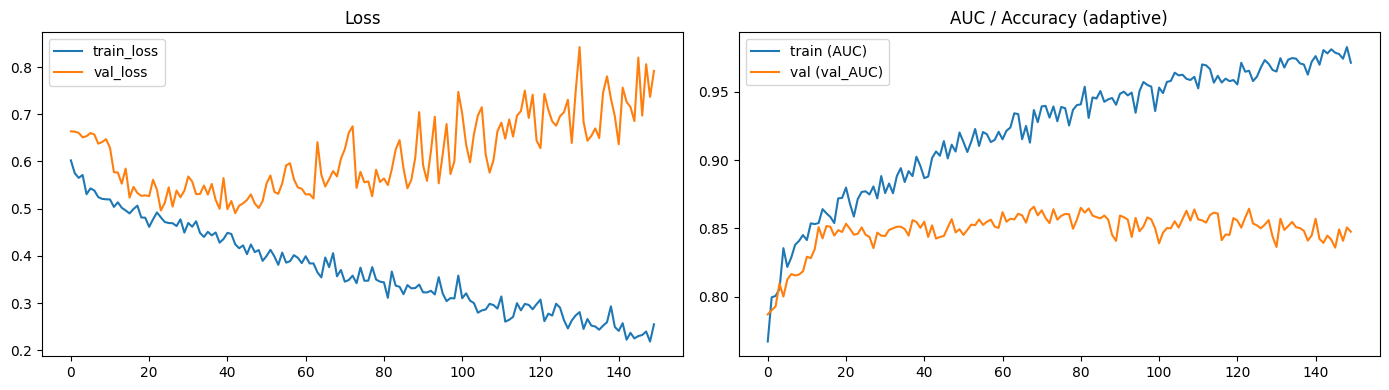

In [15]:
# Cell 9 (replacement): Robust training-curve plotting and debug info
hist = history.history
print("History keys available:", list(hist.keys()))

def plot_history_adaptive(hist):
    fig, axes = plt.subplots(1,2, figsize=(14,4))

    # Loss
    if 'loss' in hist:
        axes[0].plot(hist['loss'], label='train_loss')
    if 'val_loss' in hist:
        axes[0].plot(hist['val_loss'], label='val_loss')
    axes[0].set_title('Loss')
    axes[0].legend()

    # Find an AUC-like metric key (train + val)
    auc_candidates = ['auc', 'AUC', 'binary_auc', 'val_auc', 'val_AUC', 'auc_1']
    train_auc_key = None
    val_auc_key = None
    for k in hist.keys():
        lk = k.lower()
        if 'auc' in lk and not k.startswith('val'):
            train_auc_key = k
        if 'auc' in lk and k.startswith('val'):
            val_auc_key = k

    # If no auc found, fall back to 'accuracy' keys
    if train_auc_key is None:
        for k in ['accuracy', 'acc', 'AUC', 'auc']:
            if k in hist and not k.startswith('val'):
                train_auc_key = k
                break
    if val_auc_key is None:
        for k in ['val_accuracy', 'val_acc', 'val_AUC', 'val_auc']:
            if k in hist and k in hist:
                val_auc_key = k
                break

    # Plot whichever metric we found
    if train_auc_key:
        axes[1].plot(hist[train_auc_key], label=f"train ({train_auc_key})")
    if val_auc_key:
        axes[1].plot(hist[val_auc_key], label=f"val ({val_auc_key})")
    if not train_auc_key and not val_auc_key:
        axes[1].text(0.5, 0.5, "No AUC/Accuracy-like metric found\n(Check model.compile metrics)",
                     ha='center', va='center', fontsize=12)
    axes[1].set_title('AUC / Accuracy (adaptive)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_history_adaptive(hist)



In [16]:
# Cell 10: Load best model and evaluate
from tensorflow.keras.models import load_model
best_model = load_model(model_path, compile=True)  # Note: if custom objects used, adjust accordingly

# Evaluate
results = best_model.evaluate(X_test_c, y_test, verbose=0)
print("Test results (loss, AUC, accuracy):", results)


Test results (loss, AUC, accuracy): [1.1060625314712524, 0.7343089580535889, 0.008620689623057842]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Test ROC AUC: 0.7298, AP: 0.5848

Confusion Matrix:
 [[49 26]
 [13 28]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7903    0.6533    0.7153        75
           1     0.5185    0.6829    0.5895        41

    accuracy                         0.6638       116
   macro avg     0.6544    0.6681    0.6524       116
weighted avg     0.6943    0.6638    0.6708       116



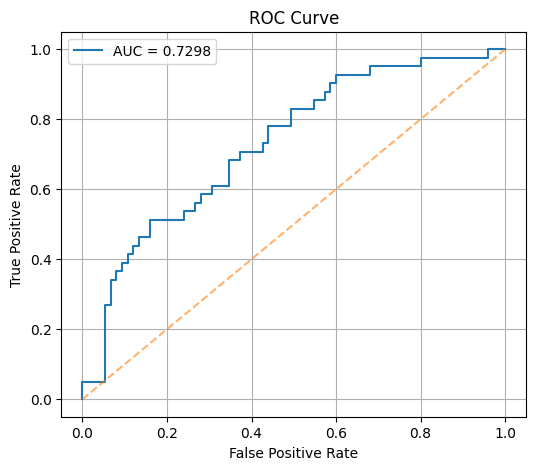

In [17]:
# Cell 11: Predictions and metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_curve, average_precision_score

y_pred_prob = best_model.predict(X_test_c).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)
print(f"Test ROC AUC: {roc_auc:.4f}, AP: {ap_score:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], '--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(100, 8, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(200, 8, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 8, 1))']
  warnings.warn(

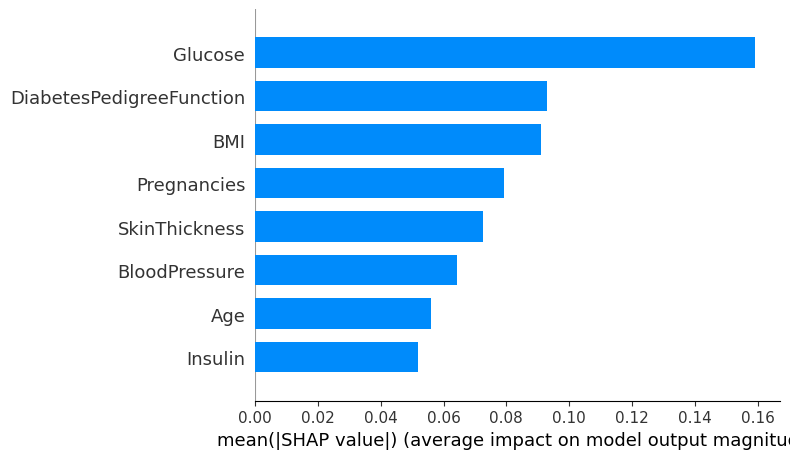

In [18]:
# Cell 12: SHAP explanation (optional). Install if needed.
# Note: SHAP can be slow; use a small background sample.

!pip install shap -q

import shap

# Use a small background set for KernelExplainer or DeepExplainer. For TF models, DeepExplainer works.
background = X_train_c[np.random.choice(X_train_c.shape[0], min(100, X_train_c.shape[0]), replace=False)]
explainer = shap.DeepExplainer(best_model, background)
# explain a subset of test examples
to_explain = X_test_c[np.random.choice(X_test_c.shape[0], min(50, X_test_c.shape[0]), replace=False)]
shap_values = explainer.shap_values(to_explain)
# shap_values is a list (for multiclass). For binary, shap_values[0] is returned
# Reduce for plotting: mean absolute across channels
shap.summary_plot(np.squeeze(shap_values), to_explain.reshape(to_explain.shape[0], to_explain.shape[1]), feature_names=df_clean.drop(columns=[TARGET]).columns.tolist(), plot_type="bar")


In [19]:
# Cell 13: Save scaler and model for later use, and make downloadable
import joblib
joblib.dump(scaler, "scaler.save")
best_model.save("diabetes_cnn_model.h5")

# In Colab, provide download links
from google.colab import files
files.download("diabetes_cnn_model.h5")
files.download("scaler.save")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# Cell 14: Example predict function for a single sample (raw features)
def predict_single(raw_features):
    """
    raw_features: 1D array-like with same order and # of features as original dataset (no target)
    Returns: (probability, label)
    """
    arr = np.array(raw_features).reshape(1, -1)
    arr_scaled = scaler.transform(arr)
    arr_c = arr_scaled.reshape((1, arr_scaled.shape[1], 1))
    prob = best_model.predict(arr_c)[0,0]
    label = int(prob >= 0.5)
    return prob, label

# Example: use first row from test as demonstration
sample_raw = X_test[0]  # scaled version; if you want original, use df rows before scaling
prob, label = predict_single(sample_raw)
print("Pred prob:", prob, "Pred label:", label, "True:", y_test[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Pred prob: 1.6065333e-05 Pred label: 0 True: 0
